In [1]:
import os
import sys
os.environ["BACKEND"]   = "numpy"
script_dir              = os.path.dirname(os.curdir)
parent_dir              = os.path.abspath(os.path.join(script_dir, '..'))
parent_dir_up           = os.path.abspath(os.path.join(parent_dir, '..'))
if parent_dir_up not in sys.path:
    sys.path.append(parent_dir_up)

from QES.Algebra.hamil_quadratic import QuadraticSelection
from QES.Algebra.Model.Noninteracting.Conserving.free_fermions import FreeFermions
from QES.general_python.common.binary import extract as Extractor
from QES.general_python.common.binary import base2int, int2base, int2binstr
from QES.general_python.physics import entropy as Entropy, density_matrix as Dens
from QES.general_python.physics.sp import correlation_matrix as Corr
from QES.general_python.common.plot import Plotter
import numpy as np


INFO:general_python.algebra.utils:63: JAX backend available and successfully imported
INFO:general_python.algebra.utils:63: 	JAX 64-bit precision enabled.
INFO:general_python.algebra.utils:63: 	JAX is available but not set as the active backend.
INFO:general_python.algebra.utils:63: **************************************************
INFO:general_python.algebra.utils:63: Backend Configuration:
INFO:general_python.algebra.utils:63: 		NumPy Version: 2.1.3
INFO:general_python.algebra.utils:63: 		SciPy Version: 1.15.2
INFO:general_python.algebra.utils:63: 		JAX Version: 0.5.3
INFO:general_python.algebra.utils:63: 		Active Backend: numpy
INFO:general_python.algebra.utils:63: 			JAX Available: True
INFO:general_python.algebra.utils:63: 			Default Seed: 42
INFO:general_python.algebra.utils:63: 		NumPy Backend Details:
INFO:general_python.algebra.utils:63: 				Main Module: numpy
INFO:general_python.algebra.utils:63: 				Random Module: Generator
INFO:general_python.algebra.utils:63: 				SciPy Mo

Create the Free Fermion Hamiltonian

In [2]:
ns      = 12
t       = 1.0
backend = 'numpy'
hamil   = FreeFermions(ns=ns, t = t, dtype = np.complex128, backend = backend, logger=None)
hamil

INFO:general_python.common.flog:241: Log file created: ./log/global.log
INFO:general_python.common.flog:241: Log level set to: info
INFO:general_python.common.flog:256: ############Global logger initialized.############


FreeFermions(ns=12, t=1.0, constant_offset=0.0)

### a) Plot the eigenenergies to see whether it is correct

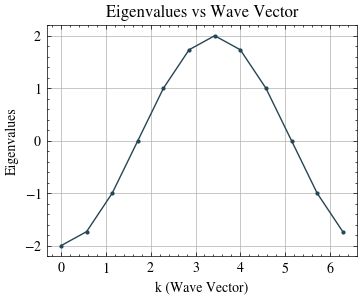

In [7]:
from QES.general_python.common.plot import Plotter

fig, ax = Plotter.get_subplots(1, 1, sizex=4, sizey=3)
k       = np.linspace(0, 2 * np.pi, hamil.ns)
ax[0].plot(k, hamil.eig_val, '-o', markersize=2)
ax[0].set_xlabel('k (Wave Vector)')
ax[0].set_ylabel('Eigenvalues')
ax[0].set_title('Eigenvalues vs Wave Vector')
ax[0].grid(True)

### b) Test whether the many body energies agree

In [12]:
n_particles = 3
arange      = np.arange(hamil.ns)
energies    = []
nh          = 0
print(f"Total number should be: {2**ns}")
for i in range(hamil.ns + 1):
    # Calculate the number of combinations
    n_elements = QuadraticSelection.all_orbitals_size(hamil.ns, i)
    print(f"\tNumber of combinations for {i} particles: {n_elements}")
    
    # Generate all combinations of orbitals
    arange, all_combinations = QuadraticSelection.all_orbitals(arange, i)
    
    for orbitals in all_combinations:
        orbitals = np.array(orbitals)
        energy   = hamil.many_body_energy(orbitals)
        energies.append(energy)
    nh += n_elements
print(f"Total number of many-body states (nh): {nh}")


Total number should be: 4096
	Number of combinations for 0 particles: 1
	Number of combinations for 1 particles: 12
	Number of combinations for 2 particles: 66
	Number of combinations for 3 particles: 220
	Number of combinations for 4 particles: 495
	Number of combinations for 5 particles: 792
	Number of combinations for 6 particles: 924
	Number of combinations for 7 particles: 792
	Number of combinations for 8 particles: 495
	Number of combinations for 9 particles: 220
	Number of combinations for 10 particles: 66
	Number of combinations for 11 particles: 12
	Number of combinations for 12 particles: 1
Total number of many-body states (nh): 4096


### c) Plot the many body energies

NameError: name 'energies' is not defined

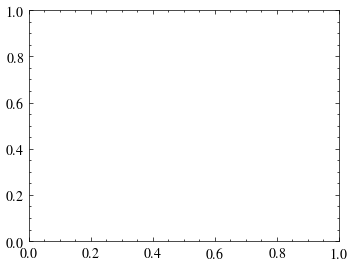

In [3]:
fig, ax = Plotter.get_subplots(1, 1, sizex=4, sizey=3)

# Sort and normalize the energies
energies_sorted     = np.sort(energies)
normalized_energies = energies_sorted / ns

# Plot the normalized energies
ax[0].plot(normalized_energies, '-o', markersize=2)
ax[0].set_xlabel('State Index')
ax[0].set_ylabel(r'$E / L$')
ax[0].set_title('Normalized Many-Body Energies')
ax[0].grid(True)

# Display the ground state energy
ground_state_energy = energies_sorted[0]
print(f"Ground state energy: {ground_state_energy}")

#! Sanity check
# Extract single-particle energies and identify negative ones
energies_sp         = hamil.eig_val
energies_sp_neg     = energies_sp[energies_sp < 0]

# Calculate the number of occupied states and the ground state energy
ground_state_occ    = len(energies_sp_neg)
ground_state        = np.sum(energies_sp_neg)

# Perform a sanity check to ensure consistency with the many-body ground state energy
assert np.isclose(ground_state, ground_state_energy), "Sanity check failed: Ground state energies do not match."
print(f"Sanity: Ground state energy = {ground_state}, Ground state occupancy = {ground_state_occ}")

### d) Test the state extractor

In [3]:
size        = ns
size_a      = 5
mask_a      = [0, 1, 3, 5, 8]
mask_a_e    = Extractor.prepare_mask(mask_a, size)

Extractor.test(size, size_a, mask_a_e, nsamples=3)

INFO:general_python.common.flog:256: State A mask = (3400) 110101001000
INFO:general_python.common.flog:256: State B mask = (695) 001010110111
INFO:general_python.common.flog:256: 
Full (152)    = 000010011000
INFO:general_python.common.flog:256:   State A bits      = 10000
INFO:general_python.common.flog:256:   State B bits      = 0001010
INFO:general_python.common.flog:256:   A scalar-mask : 00001   [24.2 µs]
INFO:general_python.common.flog:256:   B scalar‑mask : 0101000   [4.3 µs]
INFO:general_python.common.flog:256:   A vector‑mask : 00001   [2842.4 µs]
INFO:general_python.common.flog:256:   B vector‑mask : 0101000   [2.5 µs]
INFO:general_python.common.flog:256: ++++++++++++++++++++++++++++++++++++++++++++++++++
INFO:general_python.common.flog:256: 
Full (3137)    = 110001000001
INFO:general_python.common.flog:256:   State A bits      = 01011
INFO:general_python.common.flog:256:   State B bits      = 1000000
INFO:general_python.common.flog:256:   A scalar-mask : 11010   [5.5 µs]
IN

### e) Reduced density matrix for a given state from the Hamiltonian

In [4]:
n_occupation            = 6
dimA                    = 2**n_occupation
dimB                    = 2**(hamil.ns-n_occupation)
mask_a                  = np.array([0, 1, 2, 3, 4, 5])
mask_a_onehot           = Extractor.to_one_hot(mask_a, hamil.ns)
print(f"Mask for the lattice possitions on A : {mask_a}")
print(f"\t{mask_a_onehot}")
W                       = hamil.eig_vec
W_A                     = W[:, mask_a]
W_A_CT                  = W_A.conj().T
print(f"\t\tShape W: {W.shape}")
print(f"\t\tShape W_A: {W_A.shape}")
print(f"\t\tShape W_A_CT: {W_A_CT.shape}")
arange, orb_4_mb_state  = QuadraticSelection.ran_orbitals(hamil.ns, n_occupation)
orb_4_mb_state_1_hot    = Extractor.to_one_hot(orb_4_mb_state, hamil.ns)
orb_4_mb_state_binary   = base2int(orb_4_mb_state_1_hot)
print(f"Choosing orbitals {orb_4_mb_state}")
print(f"\t{orb_4_mb_state_1_hot}")
print(f"\t{orb_4_mb_state_binary}, {int2binstr(orb_4_mb_state_binary, hamil.ns)}")

correlation_matrix      = Corr.corr_single(W_A, orb_4_mb_state_1_hot, W_A_CT = W_A_CT, raw = True, subtract_identity=True)
corr_val, _             = np.linalg.eigh(correlation_matrix)
entropy_correlation     = Entropy.entropy(corr_val, typek = Entropy.Entanglement.SINGLE)
print(f"Entropy from single particle correlation: {entropy_correlation:.4e}")

many_body_state         = hamil.many_body_state(orb_4_mb_state)
red_dens_mat_schmidt,_  = Dens.schmidt_numba(many_body_state, dimA=dimA, dimB=dimB, eig=False)
entropy_many_body       = Entropy.entropy(red_dens_mat_schmidt, typek = Entropy.Entanglement.VN)
print(f"Entropy from many-body state: {entropy_many_body:.4e}")

Mask for the lattice possitions on A : [0 1 2 3 4 5]
	[1 1 1 1 1 1 0 0 0 0 0 0]
		Shape W: (12, 12)
		Shape W_A: (12, 6)
		Shape W_A_CT: (6, 12)
Choosing orbitals [10  9  0  8  6  3]
	[1 0 0 1 0 0 1 0 1 1 1 0]
	2350, 100100101110
Entropy from single particle correlation: 2.7534e+00
Entropy from many-body state: 2.7534e+00
